In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
%matplotlib inline

Load raw calibration data

In [4]:
# Name of file with calibration data
cal_file = "../../data/9_28_21/9_28_21_calibration2.lvm"

# Load data with pandas read_csv function
cal_data = pd.read_csv(
    cal_file,      # load file
    sep = '\t',    # define separator
    skiprows = 23, # skip labview junk
    usecols=np.arange(1,7), # select columns with relevant data
    names = [      # rename columns for make_regression function
        'yellow_g', 'red_g', 'blue_g', # gauges
        'yellow_p', 'red_p', 'blue_p', # pots
    ]
)

In [5]:
cal_data

,yellow_g,red_g,blue_g,yellow_p,red_p,blue_p
0,4.323592,4.577590,4.415512,2.333839,1.139864,1.823249
1,4.322292,4.577915,4.413563,2.331241,1.138240,1.821625
2,4.320343,4.578564,4.410640,2.331890,1.138565,1.822274
3,4.316121,4.580189,4.409340,2.331241,1.137591,1.820650
4,4.320668,4.574017,4.413238,2.331241,1.137915,1.821300
...,...,...,...,...,...,...
7775,1.887885,2.490394,2.143180,0.734836,0.465899,0.502602
7776,1.888534,2.489095,2.145129,0.735485,0.465575,0.502277
7777,1.887560,2.490394,2.147727,0.736135,0.466224,0.502602
7778,1.890808,2.490070,2.146753,0.737434,0.468173,0.504226


Make linear regression model with sklearn

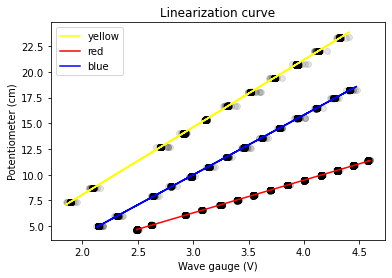

In [6]:
def make_regression(data, color, plot = True):
    """
    Uses sklearn linear regression tool to make linear models for each wave gauge
        data - pandas DataFrame with specific column naming convention
        color - color of wave gauge/pot unit
        plot - decides whether or not to make a plot of the result
    Returns: 
        Linear regression model
        
    """
    # values converts it into a numpy array
    # -1 means that calculate the dimension of rows, but have 1 column
    
    X = data.loc[:, color + "_g"].values.reshape(-1, 1) # voltage as input
    Y = data.loc[:, color + "_p"].values.reshape(-1, 1) * 10 # potentiometer "height" as output
    linear_regressor = LinearRegression()
    model = linear_regressor.fit(X, Y)
    
    if plot:
        plt.scatter(X, Y, color = 'k', alpha = 0.1)
        plt.plot(X, model.predict(X), color = color, label = color)
        plt.ylabel("Potentiometer (cm)")
        plt.xlabel("Wave gauge (V)")
        plt.title("Linearization curve")
        plt.legend()
    return model

yellow_model = make_regression(cal_data, "yellow")
red_model = make_regression(cal_data, "red")
blue_model = make_regression(cal_data, "blue")

Take sklearn model and put it in y=mx+b form, store as `lambda` function

In [5]:
def model_func(model):
    '''
    extract line equation from sklearn linear regression
    '''
    # Slope of line is rise / run, run = 1
    b = model.predict([[0]]).tolist()[0][0]
    m = model.predict([[1]]).tolist()[0][0] - b
    
    # Return line with no intercept - assumes data is centered on mean
    return lambda x: m * x

yellow_func = model_func(yellow_model)
blue_func = model_func(blue_model)
red_func = model_func(red_model)

## Calibration slopes
Yellow gauge

In [10]:
yellow_func(1)

6.552795795004875

Blue gauge

In [11]:
blue_func(1)

5.82344731575862

Red gauge

In [12]:
red_func(1)

3.177856066860256

Load wave data, center on mean

(50.0, 100.0)

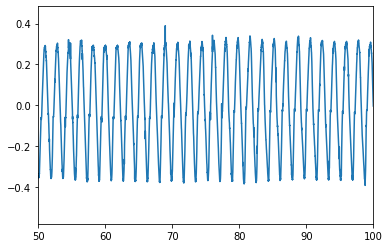

In [6]:
data_file = "../data/9_28_21/9_28_21_waves_5_1.8.lvm"
wave_data = pd.read_csv(
    data_file,
    sep = '\t', 
    skiprows = 23, 
    usecols = [0,1,2,3], 
    names = ['time', 'yellow', 'red', 'blue'],
    index_col = 0
)

# center on mean
wave_data = wave_data.apply(lambda x: x-x.mean())

plt.plot(wave_data["yellow"])
plt.xlim([50, 100]) # seconds

## `TODO`

(0.0, 5.0)

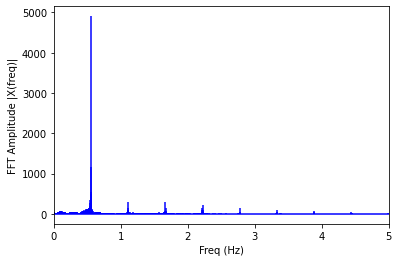

In [7]:
from numpy.fft import fft, ifft
sr = 100 # samples/second

X = fft(wave_data['yellow'])
N = len(X)
n = np.arange(N)
T = N/sr
freq = n/T 


plt.stem(freq, np.abs(X), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0,5)

In [8]:
# https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html

from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [9]:
# fs = 100
# T = 1.8
# f_target = 1 / T
# var = .99
# # f_lo = f_target - f_target * var
# # f_hi = f_target + f_target * var
# f_lo = .05
# f_hi = 5

# b, a = butter_bandpass(f_lo, f_hi, fs, order = 10)
# y = butter_bandpass_filter(wave_height['yellow'], f_lo, f_hi, fs)
# plt.plot(y[0:-3000])

NameError: name 'wave_height' is not defined

In [ ]:
wave_data

Turn voltages into heights with respective calibration curves

In [ ]:
class Measurement:
    def __init__(self, label, height_func, location):
        """
        location (1 or 2 tuple) relative to wind turbine global frame of reference
        height_func (lambda) equation to translate raw data into actual wave heights
        """
        self.label = label
        self.height_func = height_func
        self.location = location
        
    def get_height():
        